In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from ipywidgets import interact
import pandas as pd
import matplotlib.pylab as plt
import os,sys,json
from tensorflow.python.keras.callbacks import EarlyStopping
from ecg import ECG
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import time 
from imblearn.over_sampling import SMOTE


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
#Constant
version_name='class_weighted'


fs = 100

label_lookup = {'N': 0, 'A': 1, 'O': 2, '~': 3}
label_table = ['Normal Sinus Rhythm','Atrial Fibrillation', 'Other Rhythm']

def print_metrics(test_label, pred_test_output_label,average_mode=None):
    
    test_label_auc = np.zeros([len(test_label),4])
    for idx in range(len(test_label)):
        test_label_auc[idx][test_label[idx]]=1

    test_precision = metrics.precision_score(test_label, pred_test_output_label,average=average_mode)
    test_acc_score=metrics.balanced_accuracy_score(test_label, pred_test_output_label)
    test_recall_score=metrics.recall_score(test_label, pred_test_output_label, average=average_mode)
    test_f1_score=metrics.f1_score(test_label, pred_test_output_label, average=average_mode)
    test_auc_score=metrics.roc_auc_score(test_label_auc,pred_test_output)


    print("test_precision : {}".format(test_precision))
    print("test_acc_score : {}".format(test_acc_score))
    print("test_recall_score : {}".format(test_recall_score))
    print("test_f1_score : {}".format(test_f1_score))
    print("test_auc_score : {}".format(test_auc_score))
    
def plot_confusion_matrix(y_true, y_pred, title='', labels=label_table):
    cmm = confusion_matrix(y_true, y_pred)
    cmm=(cmm.astype('float')/cmm.sum(axis=1)[:,np.newaxis])*100
    fig = plt.figure(figsize=(7, 7))
    fig.subplots_adjust(wspace=0, hspace=0)
    ax = fig.add_subplot(1,1,1)
    cax = ax.matshow(cmm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = '.2f'
    thresh = cmm.max() / 2.
    for i, j in itertools.product(range(cmm.shape[0]), range(cmm.shape[1])):
        plt.text(j,i,str(format(cmm[i, j], fmt))+'%',horizontalalignment="center",color="black"if cmm[i, j] > thresh else "white")
    plt.show()

def show_db_plot(labels,idx,fs):
    #Index(['file_name', 'labels', 'label', 'db', 'path'], dtype='object')
    #key 
    file_name = labels.file_name[idx]
    #plot data 
    plt_data = np.load(labels.path[idx])
    time = np.arange(plt_data.shape[0])*1/fs
    #setip fig 
    fig = plt.figure(figsize=(15,5),facecolor='w')
    fig.subplots_adjust(wspace=0,hspace=0.05)
    ax1 = plt.subplot2grid((1,1),(0,0))
    ax1.plot(time,plt_data,'-k',lw=2)
    #Axes labels
    ax1.set_title('FileName:  {}_{}\nLabel:  {}'.format(labels.db[idx],labels.file_name[idx],labels.label[idx]),fontsize=20)
    ax1.set_xlabel('Time , seconds',fontsize=20)
    ax1.set_ylabel('ECG',fontsize=20)
    ax1.set_xlim([time.min(),time.max()])
    plt.yticks(fontsize=12)
    plt.show()



def pre_process(fs,length,waveform):
    try:
        ecg = ECG(waveform=waveform, filter_bands=[3, 45],fs = fs)
        waveform = ecg.filtered
        if len(waveform)>length:
            waveform=waveform[0:length]
        diff_len = length-len(waveform)
        waveform=np.pad(waveform,(int(diff_len/2),diff_len - int(diff_len/2)),'constant',constant_values=0)
    except ValueError:
        return[None]
    return waveform



class Cam(object):
    '''
    conv layer's length => model.layers[-3].output.shape[1]
    '''

    def __init__(self, model, test_label, test_input, t,fs,Th_mask=None):
        self.test_label = test_label
        self.test_input = test_input
        self.features = None
        self.results = None
        # Class activation map
        self.cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
        # cam_summary()
        self.gap_weights = model.layers[-1].get_weights()[0]
        self.fs = fs
        self.t = t
        self.cam_layer_len = model.layers[-3].output.shape[1]
        self.cam_filt =list()
        self.time_series_filt_ts = 0
        self.time_series_filt = 0
        self.Th_mask=Th_mask
        
    def update_Th_mask(self,Th_mask):
        self.Th_mask=Th_mask
    def get_predict_item(self):
        self.features, self.results = self.cam_model.predict(self.test_input)
        
        
        
    def update_parameter(self, test_label, test_input):
        self.test_label = test_label
        self.test_input = test_input

    def run_cam_show(self):
        interact(self.cam_show, t_idx=(0, self.test_input.shape[0] - 1, 1),class_idx=(0,3,1))
    
    def run_cam_show_demo(self):
        interact(self.cam_show_demo, t_idx=(0, self.test_input.shape[0] - 1, 1),class_idx=(0,3,1))

    def run_cam_show_No_label(self):
        interact(self.cam_show_No_label, t_idx=(0, self.test_input.shape[0] - 1, 1))

    def cam_show_No_label(self,t_idx):
        label_table = ['Normal Sinus Rhythm', 'Atrial Fibrillation', 'Other Rhythm']

        true_label = 'Test'
        features_for_series = self.features[t_idx]
        predict_idx = np.argmax(self.results[t_idx])
        prediction = label_table[predict_idx]

        class_act_w = self.gap_weights[:, predict_idx]

        class_act_w_list = self.gap_weights
        cam_output_list =list()
        cam_output = list()
        class_act_f = features_for_series
        for idx in range(len(label_table)):
            cam_output_list.append(np.matmul(class_act_f, class_act_w_list[:,idx]))
            cam_output.append((cam_output_list[idx] - np.min(cam_output_list[idx])) / (np.max(cam_output_list[idx]) - np.min(cam_output_list[idx])))

        #cam_output = np.matmul(class_act_f, class_act_w)
        #cam_output = (cam_output - np.min(cam_output)) / (np.max(cam_output) - np.min(cam_output))

        non_zero_index = np.where(self.test_input[t_idx][:, 0] != 0)[0]
        cam_time = np.arange(self.cam_layer_len) / (self.cam_layer_len / self.t)

        self.time_series_filt = self.test_input[t_idx, non_zero_index, 0]
        self.time_series_filt_ts = np.arange(self.time_series_filt.shape[0]) * 1 / self.fs

        
        
        cam_time_interp = np.arange(self.test_input[0].shape[0]) * 1 / self.fs
        cam_interp = list()

        for idx in range(len(label_table)):
            cam_interp.append(np.interp(cam_time_interp, cam_time, cam_output[idx]))
            self.cam_filt.append(cam_interp[idx][non_zero_index])

        # Setup figure
        fig = plt.figure(figsize=(15, 20))
        fig.subplots_adjust(wspace=0, hspace=0)
        ax1 = plt.subplot2grid((4, 5), (0, 0), colspan=5)
        ax2 = plt.subplot2grid((4, 5), (1, 0), colspan=5)
        ax3 = plt.subplot2grid((4, 5), (2, 0), colspan=5)
        ax4 = plt.subplot2grid((4, 5), (3, 0), colspan=5)


        # Set plot title
        ax1.set_title(
            'True Label: ' + true_label + '\n' +
            'Predicted Label: ' + prediction + '\n' +
            'Normal Sinus Rhythm: ' + str(self.results[t_idx][0]) +
            '     Atrial Fibrillation: ' + str(self.results[t_idx][1]) +
            '     Other Rhythm: ' + str(self.results[t_idx][2]),
            fontsize=20, y=1.03
        )

        # Plot image
        ax1.plot(self.time_series_filt_ts, self.time_series_filt, '-k', lw=1.5)

        # Axes labels
        ax1.set_ylabel('Normalized Amplitude', fontsize=22)
        ax1.set_xlim([0, self.time_series_filt_ts.max()])
        ax1.tick_params(labelbottom='off')
        ax1.yaxis.set_tick_params(labelsize=16)

        # Plot CAM
        ax2.plot(self.time_series_filt_ts, self.cam_filt[0], '-k', lw=1.5)

        # Axes labels
        ax2.set_xlabel('Time, seconds', fontsize=22)
        ax2.set_ylabel('Class Activation Map', fontsize=22)
        ax2.set_xlim([0, self.time_series_filt_ts.max()])

        ax2.set_ylim([np.min(cam_output[0]), np.max(cam_output[0])])
        ax2.xaxis.set_tick_params(labelsize=16)
        ax2.yaxis.set_tick_params(labelsize=16)

        # Plot CAM
        ax3.plot(self.time_series_filt_ts, self.cam_filt[1], '-k', lw=1.5)

        # Axes labels
        ax3.set_xlabel('Time, seconds', fontsize=22)
        ax3.set_ylabel('Class Activation Map', fontsize=22)
        ax3.set_xlim([0, self.time_series_filt_ts.max()])

        ax3.set_ylim([np.min(cam_output[1]), np.max(cam_output[1])])
        ax3.xaxis.set_tick_params(labelsize=16)
        ax3.yaxis.set_tick_params(labelsize=16)


        # Plot CAM
        ax4.plot(self.time_series_filt_ts, self.cam_filt[2], '-k', lw=1.5)

        # Axes labels
        ax4.set_xlabel('Time, seconds', fontsize=22)
        ax4.set_ylabel('Class Activation Map', fontsize=22)
        ax4.set_xlim([0, self.time_series_filt_ts.max()])

        ax4.set_ylim([np.min(cam_output[2]), np.max(cam_output[2])])
        ax4.xaxis.set_tick_params(labelsize=16)
        ax4.yaxis.set_tick_params(labelsize=16)



        plt.show()

    def cam_show(self, t_idx, class_idx):
        '''
            #class_idx :
            # class= 0,1,2 
            # predict = 3
        '''
        draw_norm=True
        label_table = ['Normal Sinus Rhythm', 'Atrial Fibrillation', 'Other Rhythm']

        true_label = label_table[self.test_label[t_idx]]
        features_for_series = self.features[t_idx]
        if class_idx ==3:
            predict_idx = np.argmax(self.results[t_idx])
        else:
            predict_idx=class_idx
        
        prediction = label_table[predict_idx]

        class_act_w = self.gap_weights[:, predict_idx]
        class_act_f = features_for_series
        cam_output = np.matmul(class_act_f, class_act_w)
        if draw_norm:
            cam_output = (cam_output - np.min(cam_output)) / (np.max(cam_output) - np.min(cam_output))
            non_zero_index = np.where(self.test_input[t_idx][:, 0] != 0)[0]
            
        non_zero_index = np.where(self.test_input[t_idx][:, 0] != None)[0]
        cam_time = np.arange(self.cam_layer_len) / (self.cam_layer_len / self.t)

        time_series_filt = self.test_input[t_idx, non_zero_index, 0]
        time_series_filt_ts = np.arange(time_series_filt.shape[0]) * 1 / self.fs

        cam_time_interp = np.arange(self.test_input[0].shape[0]) * 1 / self.fs
        cam_interp = np.interp(cam_time_interp, cam_time, cam_output)
        cam_filt = cam_interp[non_zero_index]
        self.cam_filt.append(cam_filt)
        # Setup figure
        fig = plt.figure(figsize=(15, 10))
        fig.subplots_adjust(wspace=0, hspace=0)
        ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=5)
        ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=5)

        # Set plot title
        ax1.set_title(
            'True Label: ' + true_label + '\n' +
            'Predicted Label: ' + prediction + '\n' +
            'Normal Sinus Rhythm: ' + str(self.results[t_idx][0]) +
            '     Atrial Fibrillation: ' + str(self.results[t_idx][1]) +
            '     Other Rhythm: ' + str(self.results[t_idx][2]),
            fontsize=20, y=1.03
        )

            
        # Plot image
        ax1.plot(time_series_filt_ts, time_series_filt, '-k', lw=1.5)
        
        # Axes labels
        ax1.set_ylabel('Normalized Amplitude', fontsize=22)
        ax1.set_xlim([0, time_series_filt_ts.max()])
        ax1.tick_params(labelbottom='off')
        ax1.yaxis.set_tick_params(labelsize=16)
 
        
        
        # Plot CAM
        ax2.plot(time_series_filt_ts, cam_filt, '-k', lw=1.5)

        # Axes labels
        ax2.set_xlabel('Time, seconds', fontsize=22)
        ax2.set_ylabel('Class Activation Map', fontsize=22)
        ax2.set_xlim([0, time_series_filt_ts.max()])

        ax2.set_ylim([np.min(cam_output), np.max(cam_output)])
        ax2.xaxis.set_tick_params(labelsize=16)
        ax2.yaxis.set_tick_params(labelsize=16)
        
        plt.show()


        

    def cam_show_demo(self, t_idx, class_idx):
        '''
            #class_idx :
            # class= 0,1,2 
            # predict = 3
        '''
        draw_norm=True
        label_table = ['Normal Sinus Rhythm', 'Atrial Fibrillation', 'Other Rhythm']

        true_label = label_table[self.test_label[t_idx]]
        features_for_series = self.features[t_idx]
        if class_idx ==3:
            predict_idx = np.argmax(self.results[t_idx])
        else:
            predict_idx=class_idx
        
        prediction = label_table[predict_idx]

        class_act_w = self.gap_weights[:, predict_idx]
        class_act_f = features_for_series
        cam_output = np.matmul(class_act_f, class_act_w)
        if draw_norm:
            cam_output = (cam_output - np.min(cam_output)) / (np.max(cam_output) - np.min(cam_output))
            non_zero_index = np.where(self.test_input[t_idx][:, 0] != 0)[0]
            
        non_zero_index = np.where(self.test_input[t_idx][:, 0] != None)[0]
        cam_time = np.arange(self.cam_layer_len) / (self.cam_layer_len / self.t)

        time_series_filt = self.test_input[t_idx, non_zero_index, 0]
        time_series_filt_ts = np.arange(time_series_filt.shape[0]) * 1 / self.fs

        cam_time_interp = np.arange(self.test_input[0].shape[0]) * 1 / self.fs
        cam_interp = np.interp(cam_time_interp, cam_time, cam_output)
        cam_filt = cam_interp[non_zero_index]
        self.cam_filt.append(cam_filt)
        # Setup figure
        fig = plt.figure(figsize=(15, 10))
        # Set plot title
        plt.title(
            'True Label: ' + true_label + '\n' +
            'Predicted Label: ' + prediction + '\n' +
            'Normal Sinus Rhythm: ' + str(self.results[t_idx][0]) +
            '     Atrial Fibrillation: ' + str(self.results[t_idx][1]) +
            '     Other Rhythm: ' + str(self.results[t_idx][2]),
            fontsize=20, y=1.03
        )

            
        # Plot image
        plt.plot(time_series_filt_ts, time_series_filt, '-k', lw=1.5)
        
        # Axes labels
        plt.ylabel('Normalized Amplitude', fontsize=22)
        plt.xlim([0, time_series_filt_ts.max()])
        plt.tick_params(labelbottom='off')

        #Check alert
        if self.Th_mask!=None and (predict_idx==1 or predict_idx==2):
            cam_filt_mask = cam_filt>self.Th_mask

            mask_queue = list(np.where(cam_filt_mask==True)[0])
            packet = []
            tmp = []
            prev_item = mask_queue.pop(0)
            tmp.append(prev_item)

            while(len(mask_queue)>0):
                cur_item = mask_queue.pop(0)

                if prev_item+1==cur_item:
                    tmp.append(cur_item)
                    prev_item = cur_item
                else:
                    packet.append(tmp)
                    tmp = []
                    tmp.append(cur_item)
                    prev_item = cur_item
            packet.append(tmp)

            range_list = []

            for draw_idx in range(len(packet)):
                range_list.append((packet[draw_idx][0],packet[draw_idx][-1]))
            for (start,end) in range_list:
                #ax1.axvspan(start,end,color='red',alpha=0.2)
                plt.plot(time_series_filt_ts[start:end],time_series_filt[start:end],color='red')


        
        plt.show()







In [ ]:
#for GPU debug
#tf.debugging.set_log_device_placement(True)

#GPU Memory관리 
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

# Load Data

## Load Process

In [ ]:
db_item = 'physionet-2017'
t=60
wave_len = fs*t
model_name='model_v1.3_ssh_'+str(fs)+'Hz_'+version_name+'.h5'
#Y:\08-intocns\deepECG-tf2-mskim\data\physionet-2017\origin\preprocessed
data_path = '/store1/08-intocns/deepECG-tf2-mskim/data/'+db_item+'/origin/preprocessed/'+str(fs)+'hz'
print(data_path)

In [ ]:
# npz_flag=False
# if npz_flag==True:
#     #processed_300_physionet.npz
#     load_npz = np.load(os.path.join(data_path,'processed_'+str(fs)+'_'+'physionet.npz'),mmap_mode='r')
#     label_npz = load_npz['labels']
#     npz_list = load_npz.files
#     npz_list.pop(npz_list.index('labels'))
#     print(len(npz_list))
#     data = []
#     label = []

#     for idx,key in enumerate(npz_list):
#         start_time = time.time()
#         if label_npz[idx]==3:
#             continue
#         data.append(load_npz[key])
#         label.append(label_npz[idx])
#         end_time = time.time()
#         #print(end_time-start_time)
#     input_data = np.expand_dims(np.array(data),axis=2)
#     input_label = np.array(label)
# else:
#     #load labels.csv
#     load_label_file=pd.read_csv(data_path+'/labels.csv')
#     label = [label_lookup[item] for idx,item in enumerate(list(load_label_file.label))]
#     data = np.empty((0,wave_len))
#     for idx, file_name in enumerate(load_label_file.file_name):
#         load_npy = np.load(data_path+'/'+file_name+'.npy')
#         data=np.append(data,np.array([load_npy]),axis=0)
#     input_data = np.expand_dims(data,axis=2)
#     input_label = np.array(label)

In [ ]:
# np.save('input_data_100',input_data)
# np.save('input_label_100',input_label)

In [ ]:
input_data = np.load('input_data_100.npy')
input_label = np.load('input_label_100.npy')

In [ ]:
nsr, af, other =np.bincount(input_label)
total = nsr + af + other
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n    AF: {} ({:.2f}% of total)\n    Other: {}({:.2f}% of total)\n'.format(
    total, nsr, 100 * nsr / total,  af, 100 * af / total,  other, 100 * other / total))


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight = "balanced" , 
                     classes=np.unique(input_label), 
                     y = input_label)

In [10]:
# trainval_input, test_input, trainval_label, test_label =  train_test_split(input_data, input_label, test_size=0.33, random_state=42, stratify=input_label)
# train_input, val_input, train_label, val_label =  train_test_split(trainval_input, trainval_label, test_size=0.33, random_state=42, stratify=trainval_label)

In [11]:
train_input, test_input, train_label, test_label =  train_test_split(input_data, input_label, test_size=0.2, random_state=42, stratify=input_label)

In [12]:
class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}
class_weight

{0: 0.5441584158415842, 1: 3.7235772357723578, 2: 1.1188925081433225}

Epoch 1/100
462/462 [==============================] - 31s 61ms/step - loss: 1.0373 - accuracy: 0.5334 - val_loss: 1.3464 - val_accuracy: 0.4002
Epoch 2/100
462/462 [==============================] - 27s 59ms/step - loss: 0.9223 - accuracy: 0.5875 - val_loss: 4.2868 - val_accuracy: 0.0955
Epoch 3/100
462/462 [==============================] - 28s 60ms/step - loss: 0.8169 - accuracy: 0.6484 - val_loss: 0.7126 - val_accuracy: 0.7236
Epoch 4/100
462/462 [==============================] - 28s 60ms/step - loss: 0.7294 - accuracy: 0.6850 - val_loss: 0.5564 - val_accuracy: 0.7600
Epoch 5/100
462/462 [==============================] - 28s 60ms/step - loss: 0.7137 - accuracy: 0.7041 - val_loss: 0.6089 - val_accuracy: 0.7393
Epoch 6/100
462/462 [==============================] - 28s 60ms/step - loss: 0.6648 - accuracy: 0.7138 - val_loss: 0.7455 - val_accuracy: 0.7266
Epoch 7/100
462/462 [==============================] - 28s 60ms/step - loss: 0.6419 - accuracy: 0.7299 - val_loss: 0.7652 - val_ac

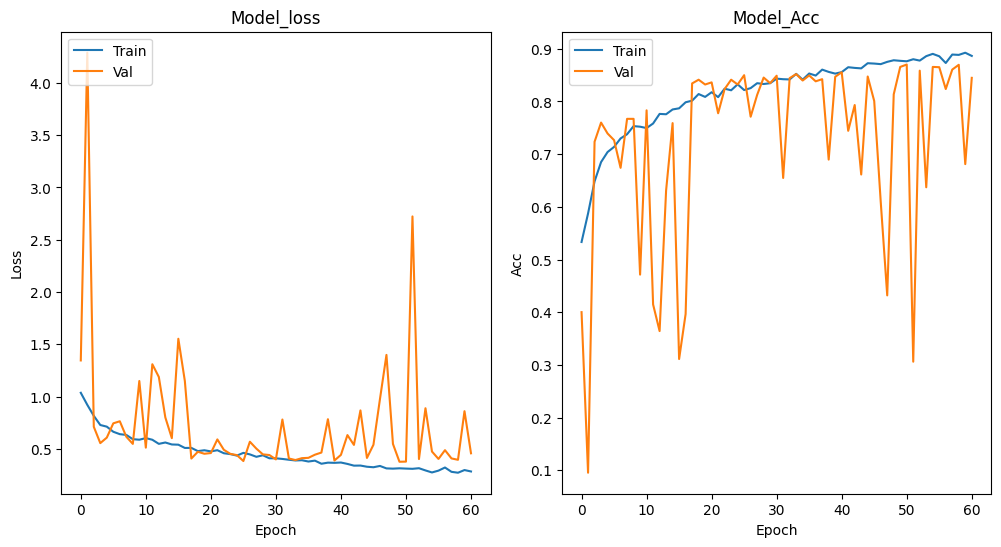

In [49]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

with tf.device('/gpu:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(input_shape=(wave_len,1),kernel_size=24,strides=1,padding='same',use_bias=True,filters=320,dilation_rate=1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2,strides=2, padding='same'),
        tf.keras.layers.Dropout(.3),

        # 2nd layer
        tf.keras.layers.Conv1D(kernel_size=16,strides=1,padding='same',use_bias=True,filters=256,dilation_rate=2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 3rd layer
        tf.keras.layers.Conv1D(kernel_size=16,strides=1,padding='same',use_bias=True,filters=256,dilation_rate=4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 4th layer
        tf.keras.layers.Conv1D(kernel_size=16,strides=1,padding='same',use_bias=True,filters=256,dilation_rate=4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 5th layer
        tf.keras.layers.Conv1D(kernel_size=16,strides=1,padding='same',use_bias=True,filters=256,dilation_rate=4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 6th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=128,dilation_rate=4),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2,strides=2, padding='same'),
        tf.keras.layers.Dropout(.3),

        # 7th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=128,dilation_rate=6),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 8th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=128,dilation_rate=6),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 9th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=128,dilation_rate=6),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 10th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=128,dilation_rate=6),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 11th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=128,dilation_rate=8),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2,strides=2, padding='same'),
        tf.keras.layers.Dropout(.3),

        # 12th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=64,dilation_rate=8),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # 13th layer
        tf.keras.layers.Conv1D(kernel_size=8,strides=1,padding='same',use_bias=True,filters=64,dilation_rate=8),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(.3),

        # GAP layer
        tf.keras.layers.GlobalAveragePooling1D(),

        # softmax layer
        tf.keras.layers.Dense(3,activation='softmax', use_bias=False)
        ])
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}


    history=model.fit(train_input,train_label,epochs=100, batch_size=10,callbacks=[callback], validation_split=0.3, class_weight=class_weight)
    
    model.save(model_name)
    
#save test set 
data_to_store={}
data_to_store['data'] = test_input
data_to_store['labels']= test_label
save_file_name = ('test_set_{}.npz').format(model_name)
np.savez(save_file_name,**data_to_store)

#save loss/acc
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.4, hspace=0)
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2,colspan=2)
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2,colspan=2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model_loss')
ax1.legend(['Train','Val'],loc='upper left')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.set_title('Model_Acc')
ax2.legend(['Train','Val'],loc='upper left')

plt.show()
plt.savefig('trainResult_{}.png'.format(model_name))

<Figure size 640x480 with 0 Axes>

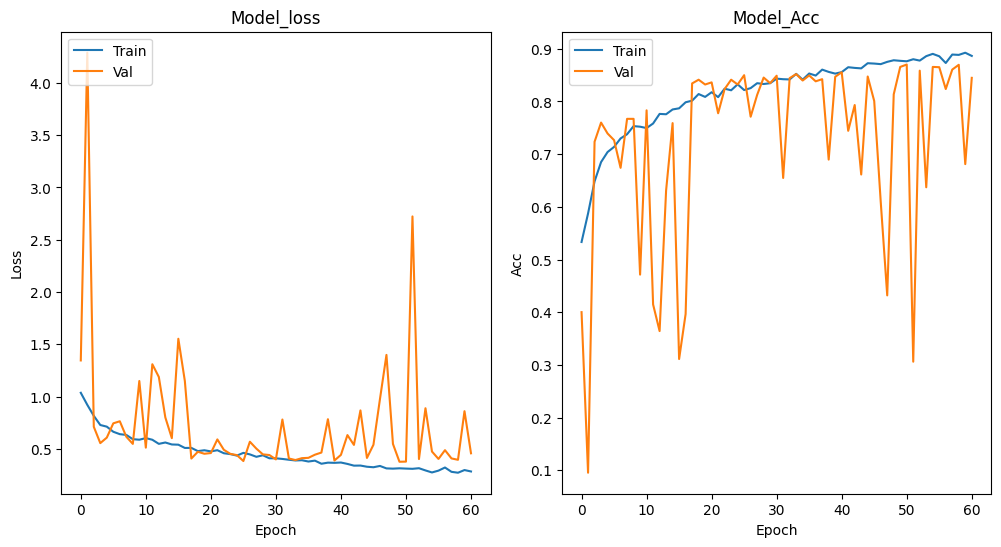

In [50]:
#훈련과정 시각화 
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.4, hspace=0)
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2,colspan=2)
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2,colspan=2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model_loss')
ax1.legend(['Train','Val'],loc='upper left')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.set_title('Model_Acc')
ax2.legend(['Train','Val'],loc='upper left')

plt.show()


In [51]:
eval_result = model.evaluate(test_input,test_label)

52/52 [==============================] - 2s 35ms/step - loss: 0.5581 - accuracy: 0.8369


## Class Activation Map for PhysioNet

In [52]:

test_cam=Cam(model,test_label,test_input,t)
test_cam.get_predict_item()


52/52 [==============================] - 2s 33ms/step


In [53]:
test_cam.run_cam_show()

interactive(children=(IntSlider(value=824, description='t_idx', max=1648), IntSlider(value=3, description='cla…

In [54]:
pred_test_output =model.predict(test_input)
pred_test_output_label =np.argmax(pred_test_output,axis=1)
pred_train_output =model.predict(train_input)
pred_train_output_label =np.argmax(pred_train_output,axis=1)

207/207 [==============================] - 7s 33ms/step


<ipython-input-36-8d120d7d9470>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-36-8d120d7d9470>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


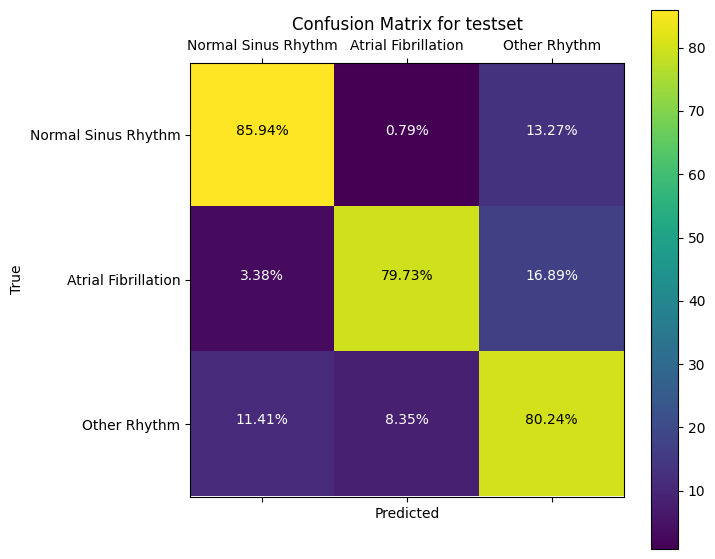

In [55]:
plot_confusion_matrix(test_label, pred_test_output_label, title='Confusion Matrix for testset')

<ipython-input-36-8d120d7d9470>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-36-8d120d7d9470>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


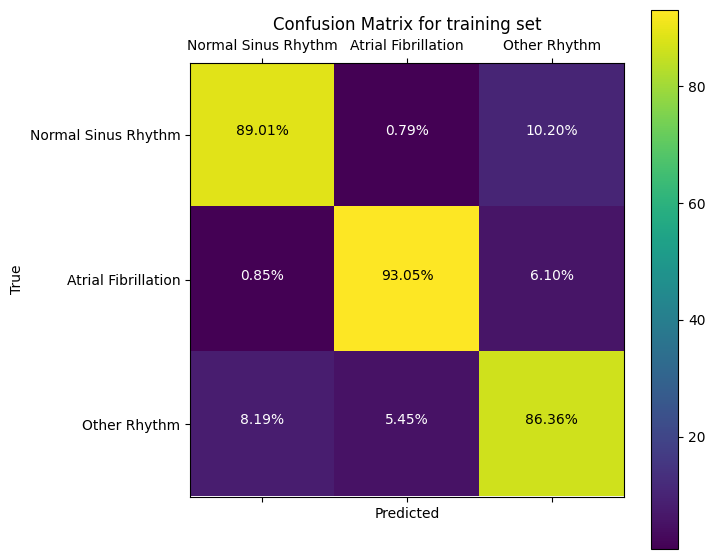

In [56]:
plot_confusion_matrix(train_label, pred_train_output_label, title='Confusion Matrix for training set')

In [60]:
# data_path = '/store1/08-intocns/deepECG-tf2-mskim/'
# load_file_name = ('test_set_{}.npz').format(model_name)
# load_npz = np.load(os.path.join(data_path,load_file_name),mmap_mode='r')
# test_input=load_npz['data']
# test_label=load_npz['labels']
# model = tf.keras.models.load_model(data_path+model_name)
#
pred_test_output =model.predict(test_input)
pred_test_output_label =np.argmax(pred_test_output,axis=1)
print_metrics(test_label, pred_test_output_label,'weighted')

52/52 [==============================] - 2s 34ms/step
test_precision : 0.8478366461926469
test_acc_score : 0.819715743248239
test_recall_score : 0.8368708308065494
test_f1_score : 0.840354154061506
test_auc_score : 0.9292924925199749


# nsrdb

<ipython-input-2-e8e3d11f3ec5>:31: RuntimeWarning: invalid value encountered in true_divide
  cmm=(cmm.astype('float')/cmm.sum(axis=1)[:,np.newaxis])*100
<ipython-input-2-e8e3d11f3ec5>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-2-e8e3d11f3ec5>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


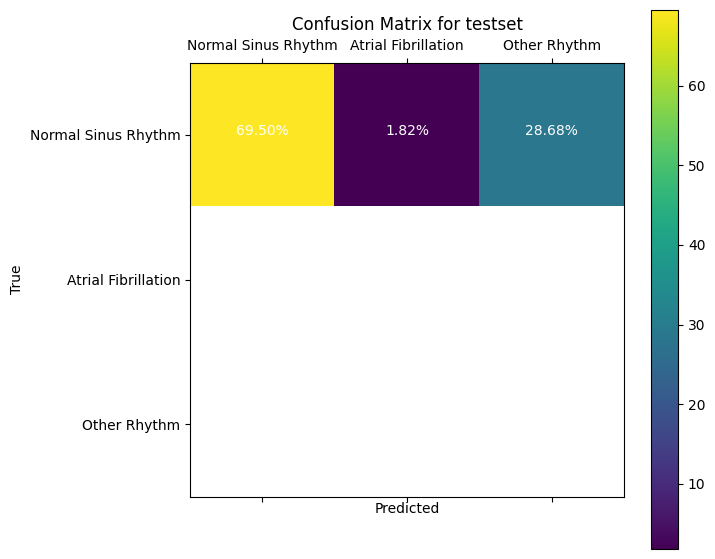

In [5]:
#import numpy as np
import tensorflow as tf
model = tf.keras.models.load_model(model_name)
input_data = np.load('nsr_data_100.npy')
input_label = np.load('nsr_label_100.npy')
pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)
plot_confusion_matrix(input_label, pred_test_output_label, title='Confusion Matrix for testset')

In [6]:
pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)

def print_metrics(test_label, pred_test_output_label,average_mode=None):
    
    test_label_auc = np.zeros([len(test_label),4])
    for idx in range(len(test_label)):
        test_label_auc[idx][test_label[idx]]=1

    test_precision = metrics.precision_score(test_label, pred_test_output_label,average=average_mode)
    test_acc_score=metrics.balanced_accuracy_score(test_label, pred_test_output_label)
    test_recall_score=metrics.recall_score(test_label, pred_test_output_label, average=average_mode)
    test_f1_score=metrics.f1_score(test_label, pred_test_output_label, average=average_mode)


    print("test_precision : {}".format(test_precision))
    print("test_acc_score : {}".format(test_acc_score))
    print("test_recall_score : {}".format(test_recall_score))
    print("test_f1_score : {}".format(test_f1_score))
    
    
print_metrics(input_label, pred_test_output_label,'weighted')

test_precision : 1.0
test_acc_score : 0.6950480742510976
test_recall_score : 0.6950480742510976
test_f1_score : 0.820092462047936


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
test_cam=Cam(model,input_label,input_data,t,fs,0.5)
test_cam.get_predict_item()
test_cam.run_cam_show()

interactive(children=(IntSlider(value=17992, description='t_idx', max=35985), IntSlider(value=1, description='…

In [8]:
test_cam.run_cam_show()

interactive(children=(IntSlider(value=17992, description='t_idx', max=35985), IntSlider(value=1, description='…

In [7]:
import tensorflow as tf
model = tf.keras.models.load_model(model_name)

<ipython-input-2-e8e3d11f3ec5>:31: RuntimeWarning: invalid value encountered in true_divide
  cmm=(cmm.astype('float')/cmm.sum(axis=1)[:,np.newaxis])*100
<ipython-input-2-e8e3d11f3ec5>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-2-e8e3d11f3ec5>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


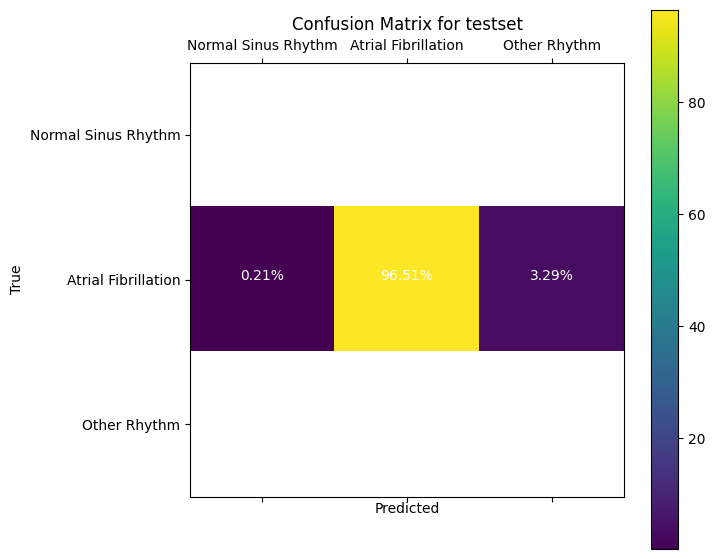

In [9]:
input_data = np.load('af_data_100.npy')
input_label = np.load('af_label_100.npy')
pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)
plot_confusion_matrix(input_label, pred_test_output_label, title='Confusion Matrix for testset')


In [ ]:
pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)

def print_metrics(test_label, pred_test_output_label,average_mode=None):
    
    test_label_auc = np.zeros([len(test_label),4])
    for idx in range(len(test_label)):
        test_label_auc[idx][test_label[idx]]=1

    test_precision = metrics.precision_score(test_label, pred_test_output_label,average=average_mode)
    test_acc_score=metrics.balanced_accuracy_score(test_label, pred_test_output_label)
    test_recall_score=metrics.recall_score(test_label, pred_test_output_label, average=average_mode)
    test_f1_score=metrics.f1_score(test_label, pred_test_output_label, average=average_mode)


    print("test_precision : {}".format(test_precision))
    print("test_acc_score : {}".format(test_acc_score))
    print("test_recall_score : {}".format(test_recall_score))
    print("test_f1_score : {}".format(test_f1_score))
    
    
print_metrics(input_label, pred_test_output_label,'weighted')

In [ ]:
input_data = np.load('pz_data_100.npy')
input_label = np.load('pz_label_100.npy')

resam_sig = []
from scipy import signal 
for sig in range(0,99):
    f_tmp = input_data[sig,0:1500]
    f = signal.resample(f_tmp, 6000)
    resam_sig.append(f)
    
pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)
plot_confusion_matrix(input_label, pred_test_output_label, title='Confusion Matrix for testset')

In [ ]:
pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)

def print_metrics(test_label, pred_test_output_label,average_mode=None):
    
    test_label_auc = np.zeros([len(test_label),4])
    for idx in range(len(test_label)):
        test_label_auc[idx][test_label[idx]]=1

    test_precision = metrics.precision_score(test_label, pred_test_output_label,average=average_mode)
    test_acc_score=metrics.balanced_accuracy_score(test_label, pred_test_output_label)
    test_recall_score=metrics.recall_score(test_label, pred_test_output_label, average=average_mode)
    test_f1_score=metrics.f1_score(test_label, pred_test_output_label, average=average_mode)


    print("test_precision : {}".format(test_precision))
    print("test_acc_score : {}".format(test_acc_score))
    print("test_recall_score : {}".format(test_recall_score))
    print("test_f1_score : {}".format(test_f1_score))
    
    
print_metrics(input_label, pred_test_output_label,'weighted')

In [ ]:
input_data = np.load('nsr_data_100.npy')
input_label = np.load('nsr_label_100.npy')

pred_test_output =model.predict(input_data)
pred_test_output_label =np.argmax(pred_test_output,axis=1)
plot_confusion_matrix(input_label, pred_test_output_label, title='Confusion Matrix for testset')

In [17]:
data = np.load('test_set_model_v1.3_ssh_100Hz_class_weighted.h5.npz')

In [19]:
input_data = data['data']
input_label = data['labels']

In [12]:

test_cam=Cam(model,input_label,input_data,t,fs,0.5)
test_cam.get_predict_item()
test_cam.run_cam_show()

interactive(children=(IntSlider(value=243, description='t_idx', max=486), IntSlider(value=1, description='clas…

In [13]:
test_cam.run_cam_show_demo()

interactive(children=(IntSlider(value=243, description='t_idx', max=486), IntSlider(value=1, description='clas…